# Acoustic Features

This notebook deals with ratio of points above linear average (RALA) [1], sharpness [2], and specific loudness moments [3].
Acoustic features not listed in this notebook are calculated by the Praat's scripts in Supplementary Material of our paper.

[1] L. Moro-Velázquez, J. A. Gómez-García, J. I. Godino-Llorente, and G. Andrade-Miranda, "Modulation Spectra Morphological Parameters: A New Method to Assess Voice Pathologies according to the GRBAS Scale," Biomed Res. Int., vol. 2015, 2015, doi: 10.1155/2015/259239.  
[2] H. Fastl and E. Zwicker, "Sharpness and Sensory Pleasantness," in Psychoacoustics: Facts and Models, H. Fastl and E. Zwicker, Eds. Berlin, Heidelberg: Springer Berlin Heidelberg, 2007, pp. 239--246.  
[3] S. Anand, L. M. Kopf, R. Shrivastav, and D. A. Eddins, "Objective Indices of Perceived Vocal Strain," J. Voice, vol. 33, no. 6, pp. 838--845, 2019.

# Ratio of Points above Linear Average (RALA)

## Visual examples

In [1]:
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from acfeatures import (
    calc_rala, _calc_modulation_spectrum, _modulation_frequency)


def plot_rala(
    center_second: float = 1.0,
) -> None:
    qualities = ("normal", "rough", "breathy", "strained")
    fs = 20000
    window_second = 0.0125
    mod_window_second = 0.18
    mod_num_bands = 1025
    mod_max_hz = 240.0

    fig, axes = plt.subplots(
        5, len(qualities), figsize=(5*len(qualities), 15),
    )

    window_sample = round(window_second * fs)
    fft_second = window_second
    fft_sample = round(fft_second * fs)
    idx_center = round(fs*center_second)
    ac_freq = np.linspace(
        0, fs, fft_sample, endpoint=False)[:1+fft_sample//2]
    mod_freq = _modulation_frequency(
        mod_num_bands=mod_num_bands,
        mod_max_hz=mod_max_hz)

    for j, quality in enumerate(qualities):
        path = f"sample_audio_preprocessed/hidaka_{quality}.wav"
        wave, fs = librosa.load(path, sr=fs)
        print(f"{quality.capitalize()} voice")
        IPython.display.display(IPython.display.Audio(wave, rate=fs))

        amp_spec = np.abs(librosa.stft(
            wave,
            n_fft=window_sample,
            hop_length=1,
            win_length=window_sample,
            window="hamming",
            center=True,
        )).T
        amp_ms = np.abs(_calc_modulation_spectrum(
            amp_spec, idx_center,
            fs=fs,
            amp_spec_shift_second=1/fs,
            mod_window_second=mod_window_second,
            mod_window_fn="hamming",
            mod_num_bands=mod_num_bands,
            mod_max_hz=mod_max_hz
        ))
        amp_ms_over_average = (amp_ms >= amp_ms.mean()).astype(np.float_)
        rala, time = calc_rala(path, fs=fs)

        im = librosa.display.specshow(
            librosa.amplitude_to_db(amp_spec.T, ref=np.max),
            x_axis='s', y_axis='hz',
            sr=fs,
            hop_length=1,
            cmap='magma',
            ax=axes[0,j])
        fig.colorbar(im, ax=axes[0,j], label="Amplitude [dB]")
        title = f"{quality.capitalize()} voice\n" \
                f"Amplitude spectrogram"
        axes[0,j].set(
            title=title,
            xlabel='Time [s]',
            ylabel='Acoustic frequency [Hz]')

        axes[1,j].grid()
        axes[1,j].plot(
            ac_freq,
            librosa.amplitude_to_db(amp_spec[idx_center].T, ref=np.max))
        title = f"{quality.capitalize()} voice\n" \
                f"Amplitude spectrum centered at {center_second} s"
        axes[1,j].set(
            title=title,
            xlabel='Acoustic frequency [Hz]',
            ylabel='Amplitude [dB]')
        axes[1,j].grid(True)

        im = axes[2,j].pcolormesh(
            mod_freq,
            ac_freq,
            librosa.amplitude_to_db(amp_ms, ref=np.max),
            cmap='magma')
        fig.colorbar(im, ax=axes[2,j], label="Amplitude [dB]")
        title = f"{quality.capitalize()} voice\n" \
                f"Modulation spectrum at {center_second} s"
        axes[2,j].set(
            title=title,
            xlabel='Modulation frequency [Hz]',
            ylabel='Acoustic frequency [Hz]')

        NT = amp_ms.shape[0]*amp_ms.shape[1]
        NA = np.sum(amp_ms >= np.mean(amp_ms))
        NB = NT - NA
        im = axes[3,j].pcolormesh(
            mod_freq, ac_freq, amp_ms_over_average, cmap='binary')
        fig.colorbar(im, ax=axes[3,j])
        title = f"{quality.capitalize()} voice\n" \
                f"Modulation spectrum over the linear average\n" \
                f"at {center_second} s (RALA: {NA / NB:.3f})"
        axes[3,j].set(
            title=title,
            xlabel='Modulation frequency [Hz]',
            ylabel='Acoustic frequency [Hz]')

        axes[4,j].plot(time, rala)
        title = f"{quality.capitalize()} voice\n" \
                f"RALA (avg.): {rala.mean():.3f}"
        axes[4,j].set(
            title=title,
            xlabel="Time [s]",
            ylabel="RALA value")
        axes[4,j].grid(True)

    fig.tight_layout()

Normal voice


Rough voice


Breathy voice


Strained voice


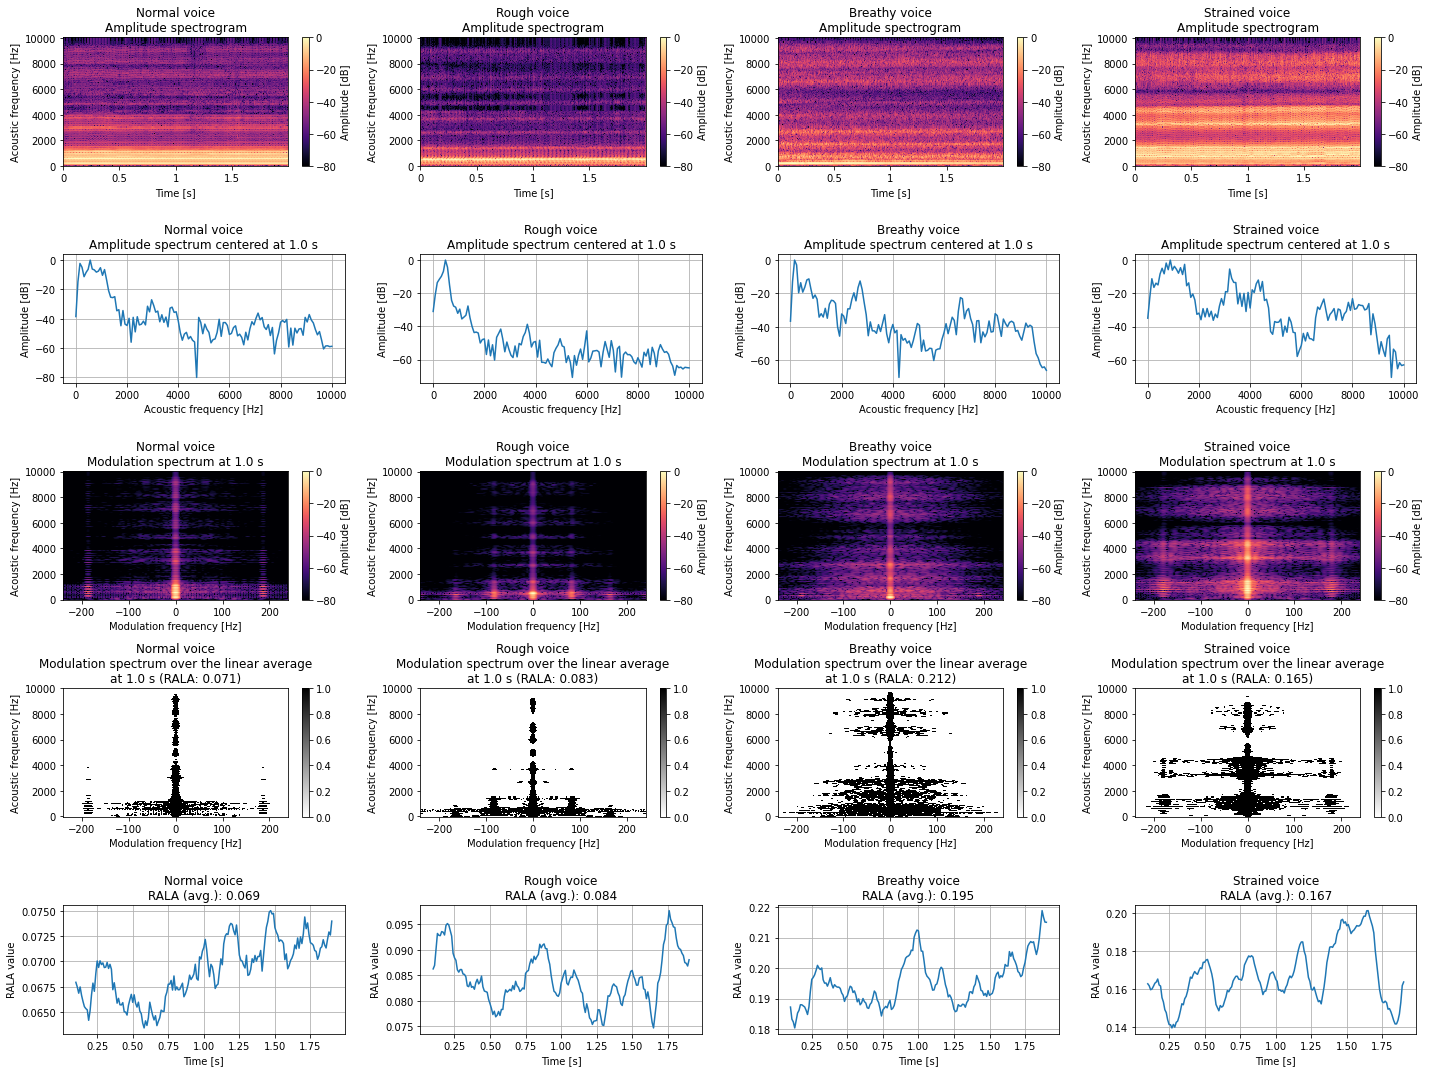

In [2]:
plot_rala()

# Sharpness and Specific Loudness Moments

## Visual examples

In [3]:
import IPython.display
import matplotlib.pyplot as plt
import mosqito

from acfeatures import calc_sharpness_loudness_moments


def plot_sharpness_loudness_moments(
    skip: float = 0.2,
) -> None:
    qualities = ("normal", "rough", "breathy", "strained")

    fig, axes = plt.subplots(
        9, len(qualities), figsize=(5*len(qualities), 27),
    )

    for j, quality in enumerate(qualities):
        path = f"sample_audio_preprocessed/hidaka_{quality}.wav"
        wave, fs = mosqito.load(path, wav_calib=1)
        print(f"{quality.capitalize()} voice")
        IPython.display.display(IPython.display.Audio(wave, rate=fs))

        results = calc_sharpness_loudness_moments(
            path, wav_calib=1, skip=skip)

        im = axes[0,j].pcolormesh(
            results["time_axis"],
            results["bark_axis"],
            results["loudness_specific"],
            cmap="magma",
        )
        plt.colorbar(im, ax=axes[0,j])
        title = f"{quality.capitalize()} voice\n" \
                f"loudness_specific"
        axes[0,j].set(title=title,
                      xlabel="Time [s]",
                      ylabel="Specific Loudness [sone/Bark]")

        for i, name in enumerate((
            "loudness",
            "loudness_moment_1",
            "loudness_moment_2",
            "loudness_moment_3",
            "loudness_moment_4",
            "loudness_skewness",
            "loudness_kurtosis",
            "sharpness",
        ), 1):
            axes[i,j].plot(results["time_axis"], results[name])
            title = f"{quality.capitalize()} voice\n" \
                    f"{name} (avg. after skip): {results[name].mean():.3f}"
            axes[i,j].set(title=title, xlabel="Time [s]")
            axes[i,j].grid(True)

    fig.tight_layout()

Normal voice


Rough voice


Breathy voice


Strained voice


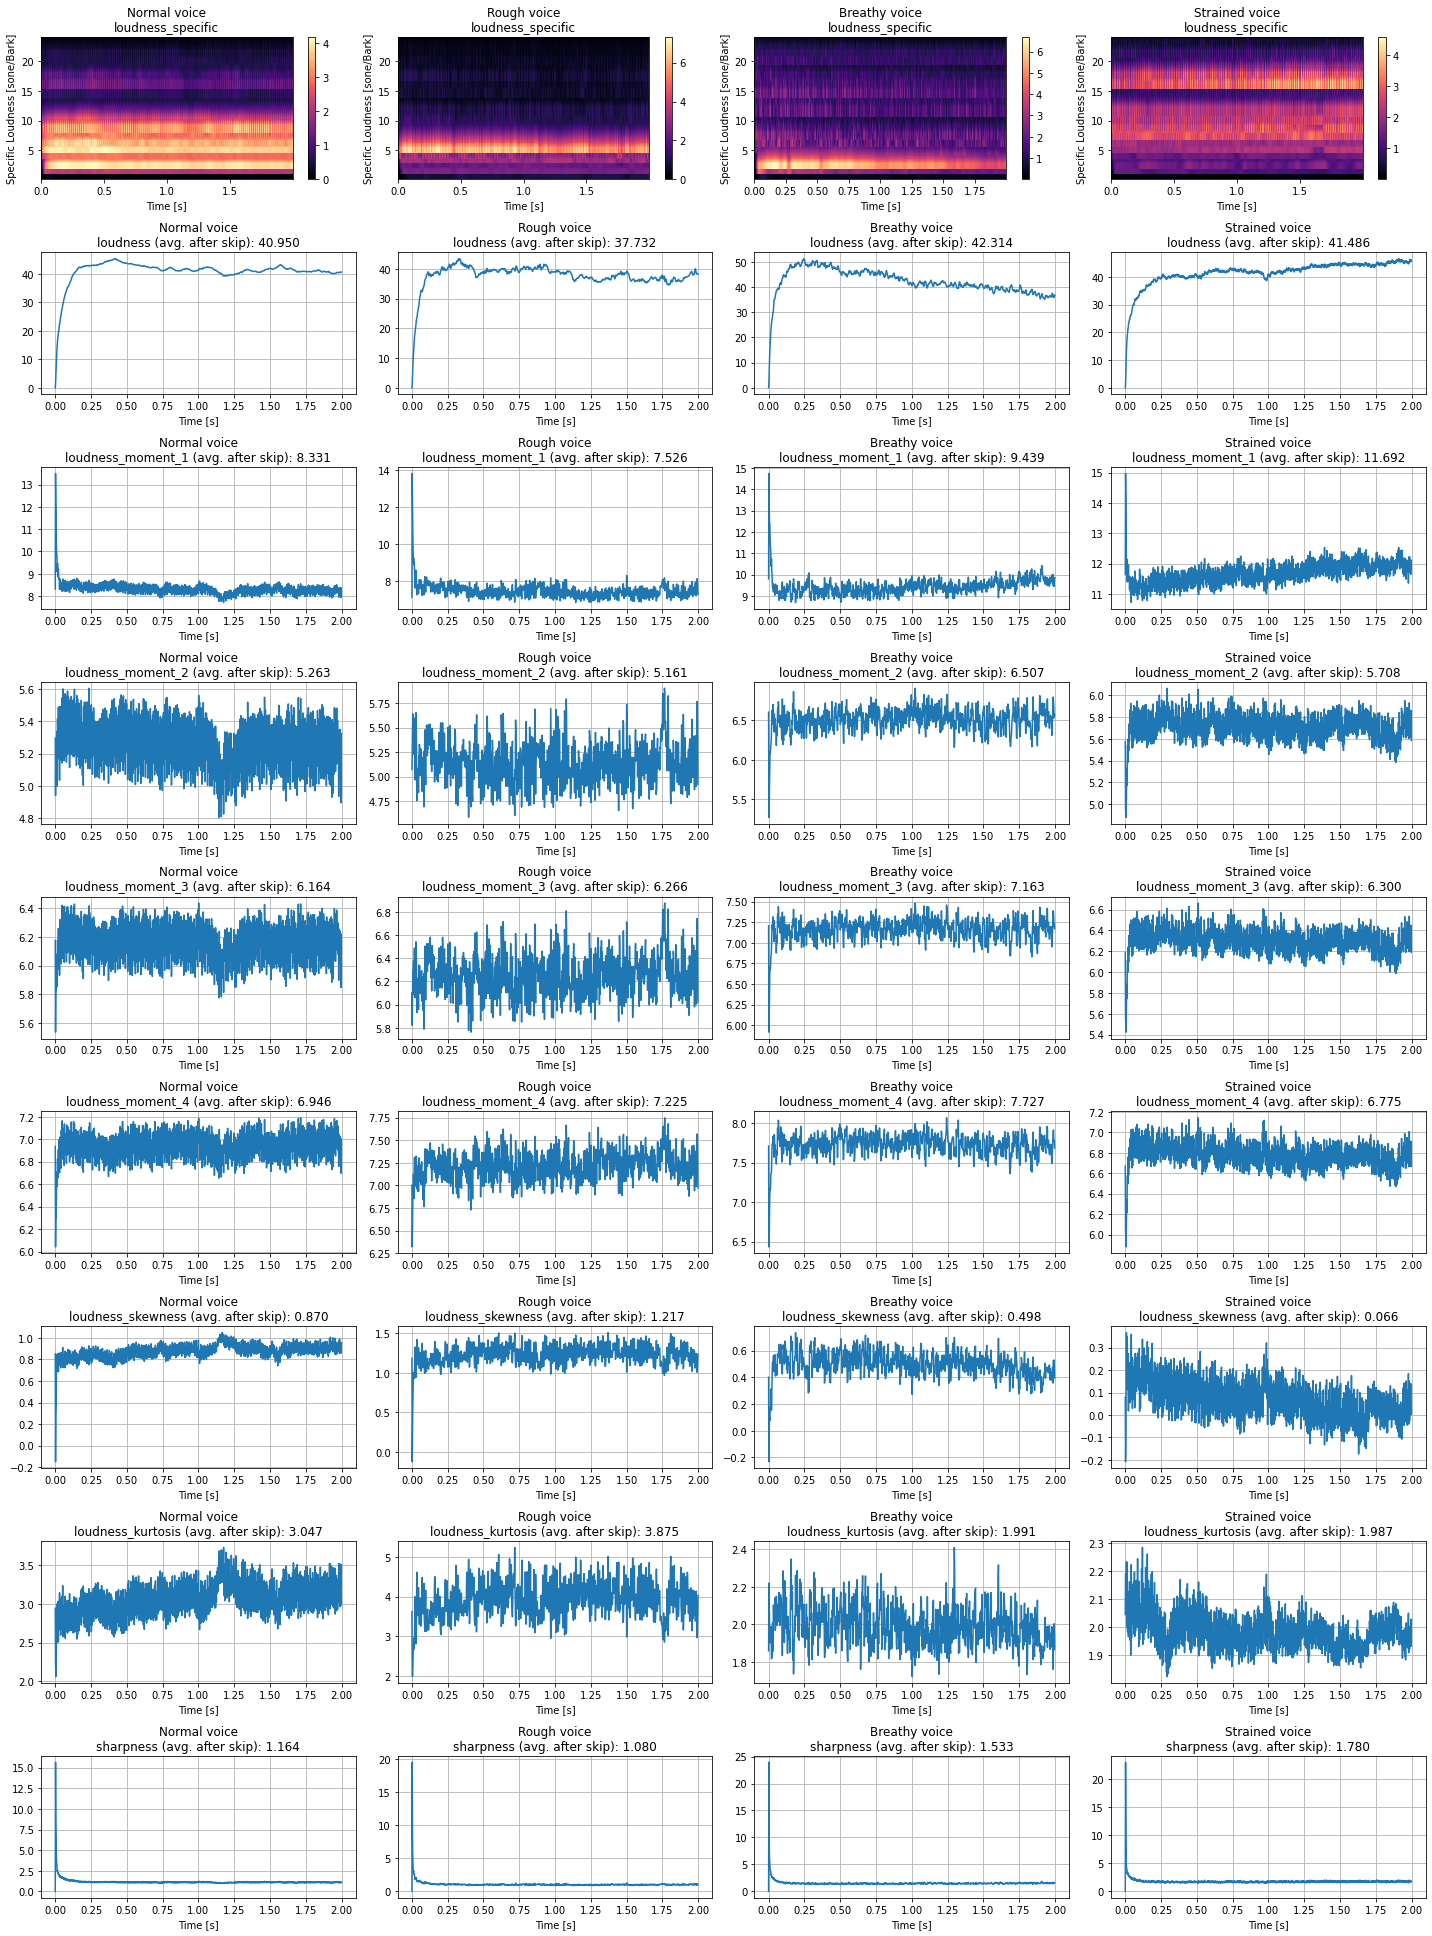

In [4]:
# If there is no skip, transient effects occur.
plot_sharpness_loudness_moments(skip=0.0)

Normal voice


Rough voice


Breathy voice


Strained voice


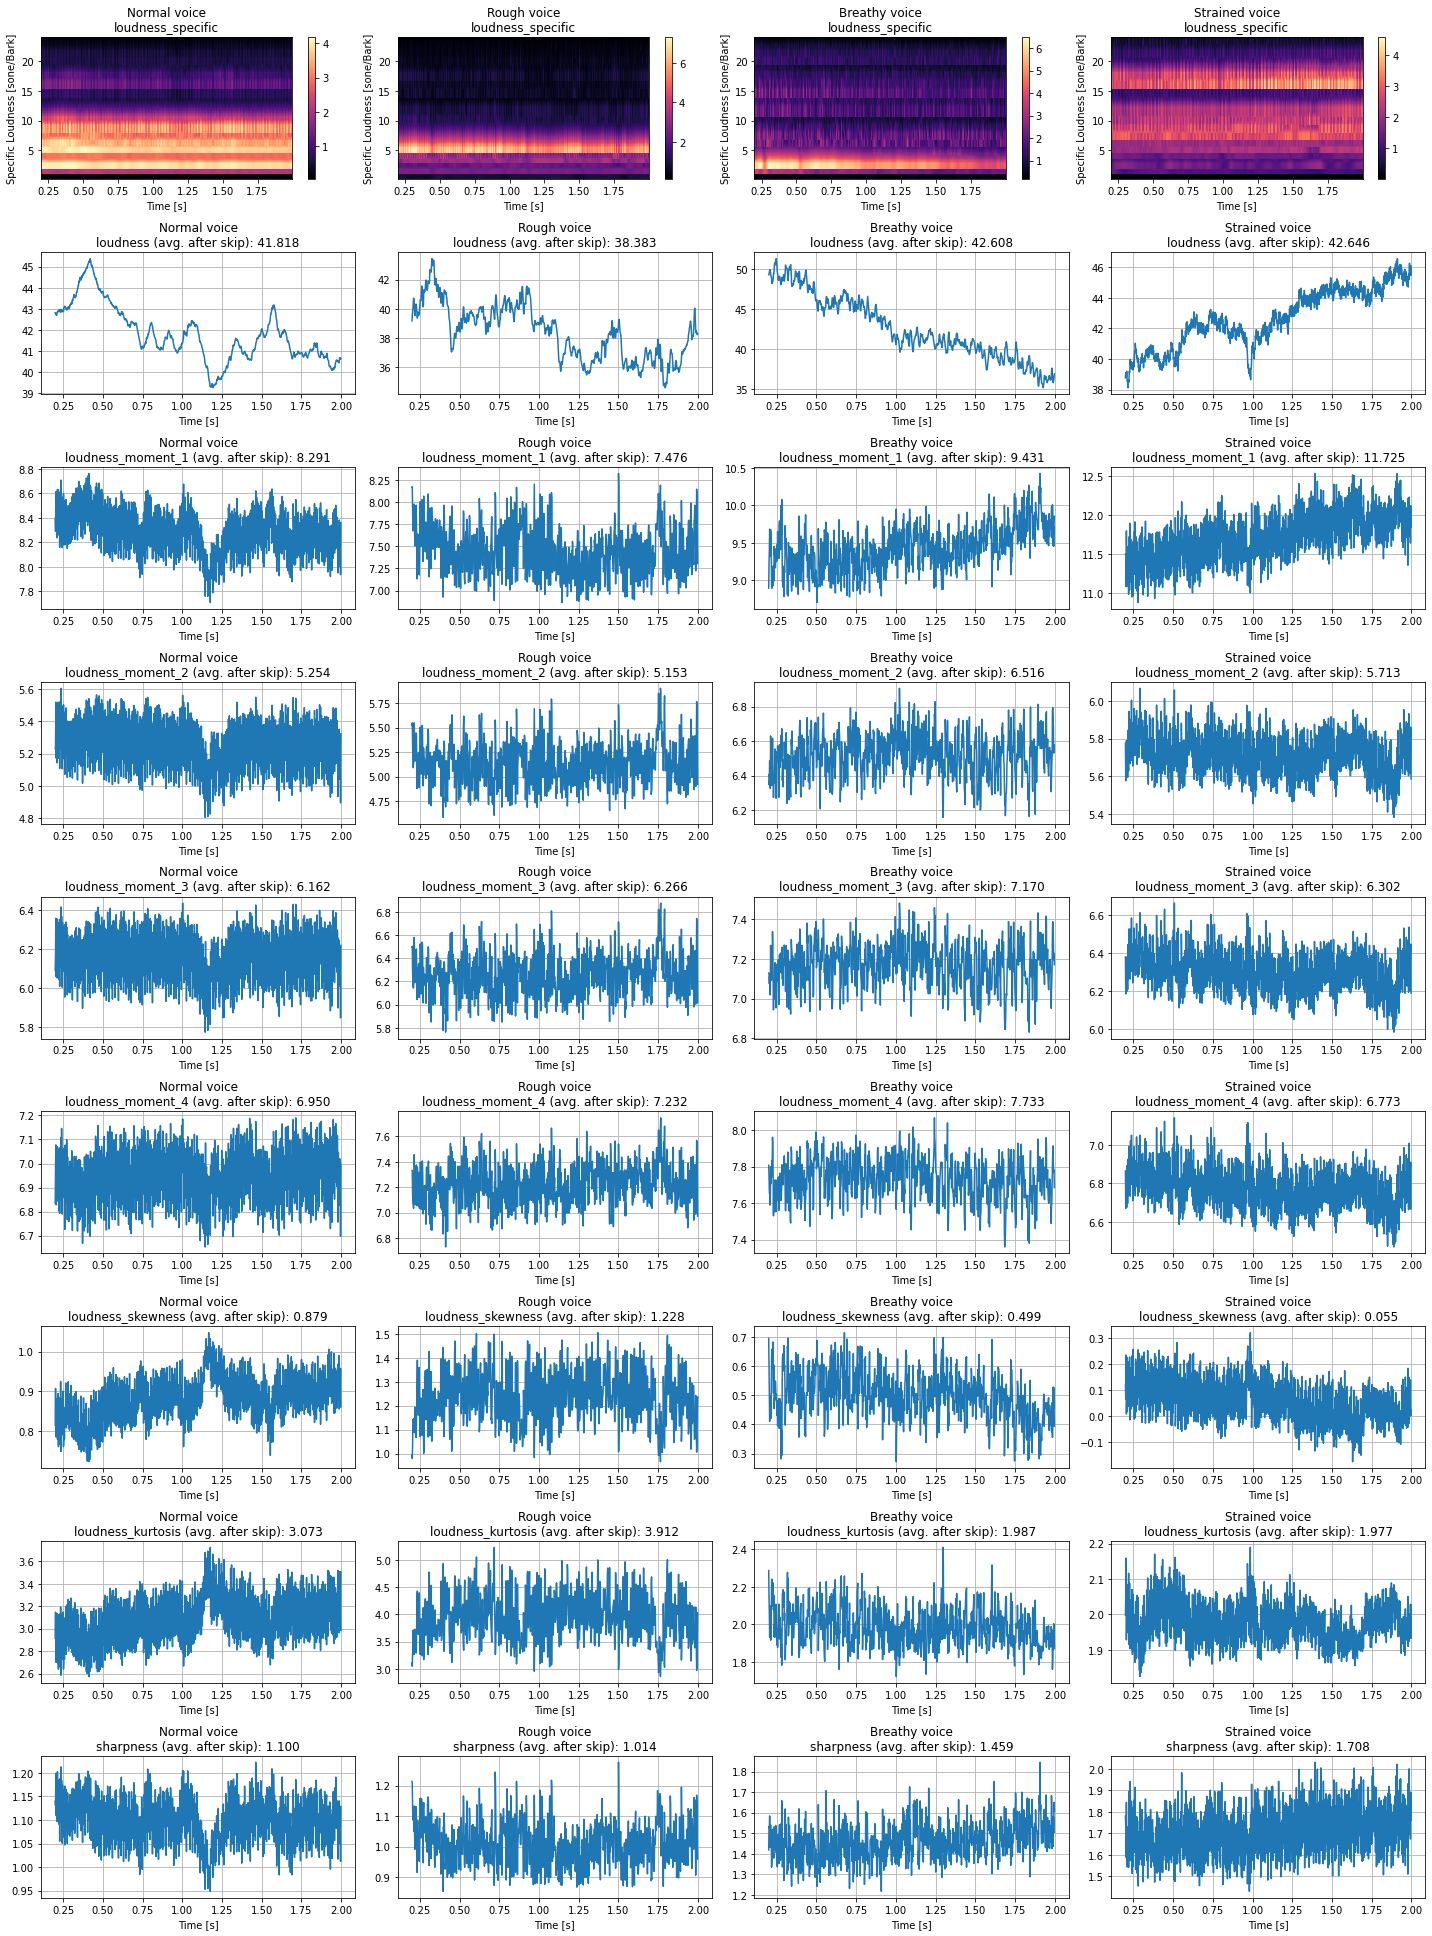

In [5]:
# Dashed line represents the skipped time
plot_sharpness_loudness_moments(skip=0.2)

# Calculation of the Acoustic Features

**Waveforms should be preprocessed using `preprocess.praat`. before the calculation of the acoustic features.**

In [6]:
from pathlib import Path
from typing import Union

import pandas as pd
from tqdm import tqdm

from acfeatures import calc_rala, calc_sharpness_loudness_moments


def calculate_acoustic_features(
    wav_directory: Union[str, Path],
    output_csv_path: Union[str, Path] = "acfeatures_python.csv",
):
    results = []
    path_list = sorted(Path(wav_directory).glob("*.wav"))
    total = len(path_list)

    for path in tqdm(path_list):
        result = {}
        result["fileID"] = path.stem

        rala, _ = calc_rala(path)
        result["RALA"] = rala.mean()

        result_sq = calc_sharpness_loudness_moments(str(path), wav_calib=1)
        result["Loudness_moment_1"] = result_sq["loudness_moment_1"].mean()
        result["Loudness_moment_2"] = result_sq["loudness_moment_2"].mean()
        result["Loudness_moment_3"] = result_sq["loudness_moment_3"].mean()
        result["Loudness_moment_4"] = result_sq["loudness_moment_4"].mean()
        result["Loudness_skewness"] = result_sq["loudness_skewness"].mean()
        result["Loudness_kurtosis"] = result_sq["loudness_kurtosis"].mean()
        result["Sharpness"] = result_sq["sharpness"].mean()

        results.append(result)
        del result, result_sq

    results = pd.DataFrame(results)
    results.to_csv(output_csv_path, index=False)

In [7]:
wav_directory = "sample_audio_preprocessed"
output_csv_path = "acfeatures_python.csv"

calculate_acoustic_features(wav_directory, output_csv_path)

100%|█████████████████████████████████████████████| 4/4 [00:59<00:00, 14.91s/it]


***

*End*